# Loading Data

In [ ]:
# Load birth data using read_csv
from pandas import read_csv, concat
from matplotlib import pyplot
df = read_csv('/content/drive/MyDrive/PFE/final data.csv',usecols=["humidity","temperature"])
print(type(df))
print(df.head())

<class 'pandas.core.frame.DataFrame'>
   humidity  temperature
0     42.76        19.55
1     42.46        19.65
2     42.25        19.77
3     41.87        19.83
4     41.62        19.93


In [ ]:
print(df.shape)

(1228, 2)


In [ ]:
print(df)

      humidity  temperature
0        42.76        19.55
1        42.46        19.65
2        42.25        19.77
3        41.87        19.83
4        41.62        19.93
...        ...          ...
1223     43.44        22.82
1224     43.47        22.82
1225     43.51        22.84
1226     43.54        22.85
1227     43.55        22.86

[1228 rows x 2 columns]


In [ ]:
print(df.describe())

          humidity  temperature
count  1228.000000  1228.000000
mean     41.377728    22.603803
std       3.981265     0.377862
min      35.460000    19.550000
25%      36.497500    22.630000
50%      43.640000    22.670000
75%      45.042500    22.720000
max      45.700000    23.070000


# Data Visualization

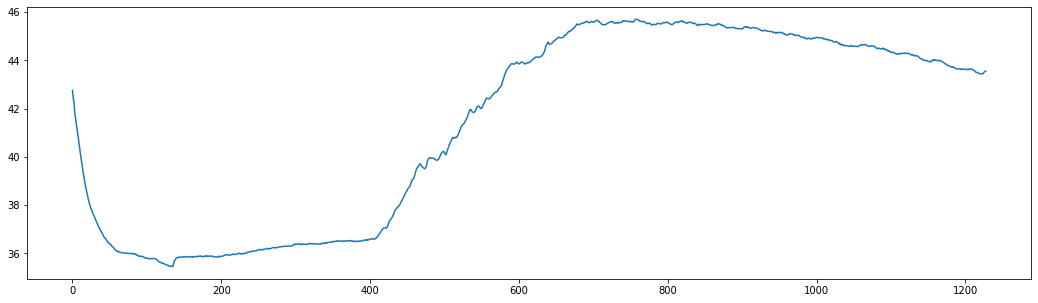

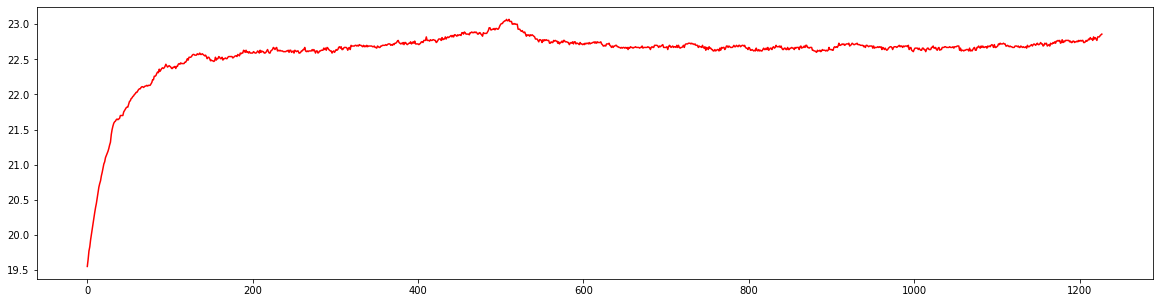

In [ ]:
pyplot.figure(figsize=(18,5))
pyplot.plot(df["humidity"])
pyplot.figure(figsize=(20,5))
pyplot.plot(df["temperature"],"r")
pyplot.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0c98ccc90>,
      dtype=object)

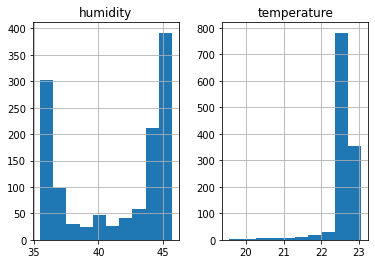

In [ ]:
df.hist()

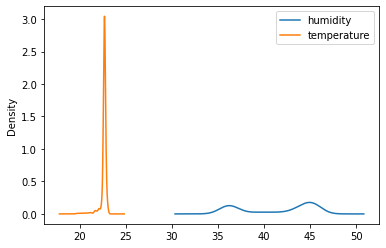

In [ ]:
df.plot(kind='kde')
pyplot.show()

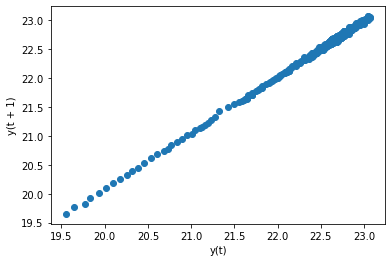

In [ ]:
from pandas.plotting import lag_plot
lag_plot(df["temperature"])

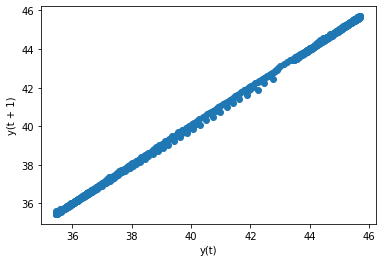

In [ ]:
lag_plot(df["humidity"])

# Persistence Forecast Model

### Converting the dataset into a supervised problem

In [ ]:
temperature_table = concat([df["temperature"].shift(1), df["temperature"]], axis=1)
temperature_table.columns = ['Temp', 'NextTemp']
print(temperature_table.head(5))

    Temp  NextTemp
0    NaN     19.55
1  19.55     19.65
2  19.65     19.77
3  19.77     19.83
4  19.83     19.93


In [ ]:
temperature_table.corr() # plots auto-correlation matrix of the temperature measures

,Temp,NextTemp
Temp,1.00000,0.99881
NextTemp,0.99881,1.00000


In [ ]:
humidity_table = concat([df["humidity"].shift(1), df["humidity"]], axis=1)
humidity_table.columns = ['Humidity', 'NextHumidity']
print(humidity_table.head(5))

   Humidity  NextHumidity
0       NaN         42.76
1     42.76         42.46
2     42.46         42.25
3     42.25         41.87
4     41.87         41.62


In [ ]:
# excluding the first and last rows
temperature_table = temperature_table[1:temperature_table.size-1]
humidity_table = humidity_table[1:humidity_table.size-1]

In [ ]:
humidity_table.corr() # plots auto-correlation matrix of the humidity measures

,Humidity,NextHumidity
Humidity,1.000000,0.999945
NextHumidity,0.999945,1.000000


### Splitting the dataset into Train and Test sets

In [ ]:
train_size = int(len(temperature_table)*0.7)

In [ ]:
temperature_train, humidity_train = temperature_table[:train_size], humidity_table[:train_size]
temperature_test, humidity_test = temperature_table[train_size:], humidity_table[train_size:]

In [ ]:
# persistence model
def model_persistence(x):
  return x

In [ ]:
# walk-forward validation
from sklearn.metrics import mean_squared_error

predictions = list()
for x in temperature_test["Temp"]:
  yhat = model_persistence(x)
  predictions.append(yhat)
test_score = mean_squared_error(temperature_test["NextTemp"], predictions)
print('Test MSE: %.6f' % test_score)

Test MSE: 0.000328


# Auto-Regression Model

### Auto-Correlation and the Lag variable

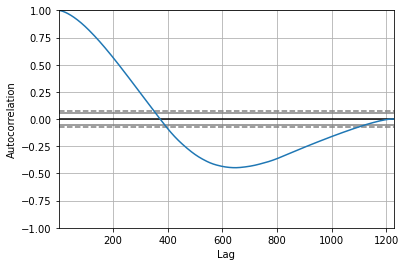

In [ ]:
# Another way (graphical) to check the auto-correlation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(humidity_table)
pyplot.show()

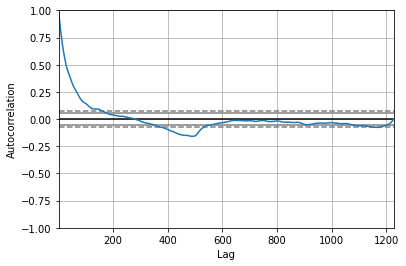

In [ ]:
autocorrelation_plot(temperature_table)
pyplot.show()

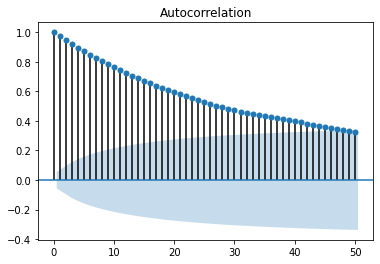

In [ ]:
# We can set the maximum lag value
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["temperature"], lags=50)
pyplot.show()

In [ ]:
# !pip install statsmodels --upgrade

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
from math import sqrt

predictions_size = 1
train_size = len(df["temperature"])-predictions_size

# train autoregression
model = AutoReg(df["temperature"][:train_size], lags=1)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

# make predictions
predictions = model_fit.predict(start=train_size, end=train_size+predictions_size - 1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[train_size+i], df["temperature"][train_size+i]))
rmse = sqrt(mean_squared_error(df["temperature"][train_size:], predictions))
print('Test RMSE: %.3f' % rmse)

# plot results
# pyplot.plot(df["temperature"][train_size:])
# pyplot.plot(predictions, color='red')
# pyplot.show()

Coefficients: intercept         0.635535
temperature.L1    0.972002
dtype: float64
predicted=22.845787, expected=22.860000
Test RMSE: 0.014


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


# AutoRegressive Integrated Moving Average Model (ARIMA)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df["temperature"], order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                 1228
Model:                 ARIMA(5, 1, 0)   Log Likelihood                3162.130
Date:                Fri, 16 Apr 2021   AIC                          -6312.261
Time:                        12:38:19   BIC                          -6281.587
Sample:                             0   HQIC                         -6300.719
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1849      0.024     -7.587      0.000      -0.233      -0.137
ar.L2          0.1767      0.027      6.568      0.000       0.124       0.229
ar.L3          0.3015      0.027     11.231      0.0

In [ ]:
predictions_size = 100
train_size = len(df["temperature"])-predictions_size

X = df["temperature"].values
train, test = X[0:train_size], X[train_size:len(X)]

history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()